## Support Vector Machine & Adaboost

In [1]:
# Import package
import numpy as np
import sklearn.datasets as ds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Prepare the data for 2 digits classification
def prepare_data(valid_digits=np.array((6, 5))):
    if len(valid_digits) != 2:
        raise Exception(
            "Error: you must specify exactly 2 digits for classification!")

    data = ds.load_digits()
    labels = data['target']
    features = data['data']
    X = features[(labels == valid_digits[0]) | (labels == valid_digits[1]), :]
    Y = labels[(labels == valid_digits[0]) | (labels == valid_digits[1]), ]
    X = X / np.repeat(np.max(X, axis=1), 64).reshape(X.shape[0], -1)

    Y[Y == valid_digits[0]] = 0
    Y[Y == valid_digits[1]] = 1

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.25, random_state=10)
    Y_train = Y_train.reshape((len(Y_train), 1))
    Y_test = Y_test.reshape((len(Y_test), 1))

    return X_train, Y_train, X_test, Y_test

In SVM, the loss function of svm is :  
$$ L(\beta) = \sum_{i=1}^n max(0,1-y_iX_i^T\beta)+\frac{\lambda}{2}|\beta|^2 $$  
Which is a hinge loss plus l2 regularization.  
This can be solved by gradient descent and the object is to maximize the margin defined by the support vector.  
$$ \frac{\partial L}{\partial \beta} = \sum_{i=1}^n 1(1-y_iX_i^T\beta <1)(-y_iX_i)+\lambda \beta$$



In [3]:
####################################################
##           1: Support vector machine            ##
####################################################
def my_SVM(X_train, Y_train, X_test, Y_test, lamb=0.01, num_iterations=200, learning_rate=0.1):
    ## X_train: Training set of features
    ## Y_train: Training set of labels corresponding to X_train
    ## X_test: Testing set of features
    ## Y_test: Testing set of labels correspdonding to X_test
    ## lamb: Regularization parameter
    ## num_iterations: Number of iterations.
    ## learning_rate: Learning rate.

    ## Function should learn the parameters of an SVM.
    ## Intercept term is needed.
    
    n = X_train.shape[0]
    p = X_train.shape[1]+1 #With intercept
    
    x1 = np.copy(X_train)
    Intercetion = np.ones((n,1))
    x1 = np.concatenate((Intercetion,x1),axis = 1)#add intercept
    y1 = np.copy(Y_train)
    y1 = 2*y1-1 #{+1,-1}
    
    n2 = X_test.shape[0]
    Intercetion = np.ones((n2,1))
    x2 = np.copy(X_test)
    x2 = np.concatenate((Intercetion,x2),axis = 1)#add intercept
    y2 = np.copy(Y_test)
    y2 = 2*y2-1
    
    #Initialization
    beta = np.zeros((p,1))
    acc_train = np.zeros((num_iterations,1))
    acc_test = np.zeros((num_iterations,1))
    
    for i in range(num_iterations):
        s = np.dot(x1,beta) #[n,1]
        de = np.multiply(s,y1)<1 #[n,1]
        indicator = np.multiply(de,y1) #[n,1]
        repeat_matrix = np.repeat(indicator,p,axis=1) #[n,p]
        dbeta = np.dot(np.ones((1,n)),(np.multiply(repeat_matrix,x1)))/n #Gradient Descent
        beta = beta +learning_rate*np.transpose(dbeta)#[p,1]
        beta[1:p] = beta[1:p] - lamb * beta[1:p] #regularization
        acc_train[i] = np.mean(np.sign(np.multiply(s,y1)))
        acc_test[i] = np.mean(np.sign(np.multiply(y2,np.dot(x2,beta))))
        
    
    ## Function should output 3 things:
    ## 1. The learned parameters of the SVM, beta
    ## 2. The accuracy over the training set, acc_train (a "num_iterations" dimensional vector).
    ## 3. The accuracy over the testing set, acc_test (a "num_iterations" dimensional vector).

    return beta, acc_train, acc_test


In Adaboost, the loss function is an exponential loss:  
$$ L(\beta) = \sum_{i=1}^n e^{(-y_i \sum_{k=1}^m)\beta_kh_k(x_i)}$$  
where the h_k(x_i) is the {+,-} weak classifiers.  
When training a AdaBoost classifier, we usually use a sequential method where we select committee members one after another so that training examples are getting separated gradually.  
Suppose a committee with k classifiers, we want to add a new member h_new. The votes are  
current committee : $$\sum_{i=1}^m \beta_kh_k(x_i)$$
add a new member: $$\sum_{i=1}^m \beta_kh_k(x_i)+\beta_{new}h_{new}(x_i)$$  
Then the loss function becomes:  
$$L(\beta) = \sum_{i=1}^n e^{-y_i (\sum_{i=1}^m \beta_kh_k(x_i)+\beta_{new}h_{new}(x_i))}$$  
Choose a new member h_new. At the point we haven’t choose a new member, β_new = 0, the above gradient can be written as
$$\frac{\partial L}{\partial \beta_{new}}=\sum_{i=1}^n e^{-y_i (\sum_{i=1}^m \beta_kh_k(x_i))}(-y_ih_{new}(x_i))
= -\sum_{i=1}^nw_iy_ih_{new}(x_i)$$  
Here we want to choose the weak classifier h_new which gives the maximum drop in loss. 
The correctly classified examples receive lower weights, whereas the wrongly classified examples get higher weights.  
To find beta_new, we set the derivative to 0, and also define an error rate,  
$$\epsilon = \frac{\sum_{i \in wrong}w_i}{\sum_i w_i}$$
$$\beta_{new} = \frac{1}{2}log(\frac{1-\epsilon}{\epsilon})$$  
It says that the weight is determined by how much error hnew made on the weighted data. This also explains the name of AdaBoost, where "Ada" means adapative.

In [4]:
######################################
## Function 2: Adaboost ##
######################################
def my_Adaboost(X_train, Y_train, X_test, Y_test, num_iterations=200):
    ## X_train: Training set of features [272,64]
    ## Y_train: Training set of labels corresponding to X_train [272,1]
    ## X_test: Testing set of features [91,64]
    ## Y_test: Testing set of labels correspdonding to X_test [91,1]
    ## num_iterations: Number of iterations.

    ## Function should learn the parameters of an Adaboost classifier.
    ## Intercept term is needed.

    n = X_train.shape[0]
    p = X_train.shape[1]+1 #(With intercept)
    threshold = 0.6 #Tuned to get highest accuracy
    
    x1 = np.copy(X_train)
    Intercetion = np.ones((n,1))
    x1 = np.concatenate((Intercetion,x1),axis = 1)#add intercept
    y1 = np.copy(Y_train)
    
    n2 = X_test.shape[0]
    Intercetion = np.ones((n2,1))
    x2 = np.copy(X_test)
    x2 = np.concatenate((Intercetion,x2),axis = 1)#add intercept
    y2 = np.copy(Y_test)
  
    x1 = 2*(x1>threshold)-1 #weak classifier = thresholding pixel intensities {+1,-1}
    y1 = 2*y1-1 #Make it become '+1' and '-1'

    x2 = 2*(x2>threshold)-1
    y2 = 2*y2-1

    #Initialization
    beta = np.zeros((p,1)) #"P" predictors, each time add one (committe)
    w = np.ones((n,1))/n
    weak_results = np.multiply(y1,x1)>0 #Weak Classifier #output[T or F](where you mad mistake)--> indicator
    acc_train = np.zeros((num_iterations,1))
    acc_test = np.zeros((num_iterations,1))
  
    for i in range(num_iterations): #re-adding new predictor
        w = w/np.sum(w)
        weighted_weak_results = np.multiply(w,weak_results) #output[True with original weight]
        weighted_accuracy = np.sum(weighted_weak_results,axis = 0) #Sum right features for each example
        e= 1 - weighted_accuracy #(error)
        j = np.where(e==min(e))[0] #minize loss to find the best predictor
        dbeta = np.log((1-e[j])/e[j])/2
        beta[j] = beta[j] + dbeta
        w = np.multiply(w,np.exp(np.multiply(-y1,x1[:,j])*dbeta)) #j:new committe
        acc_train[i] = np.mean((np.sign(np.dot(x1,beta)) == y1),axis=0)
        acc_test[i] = np.mean((np.sign(np.dot(x2,beta)) == y2),axis=0)

    ## Function should output 3 things:
    ## 1. The learned parameters of the adaboost classifier, beta
    ## 2. The accuracy over the training set, acc_train (a "num_iterations" dimensional vector).
    ## 3. The accuracy over the testing set, acc_test (a "num_iterations" dimensional vector).
    return beta, acc_train, acc_test

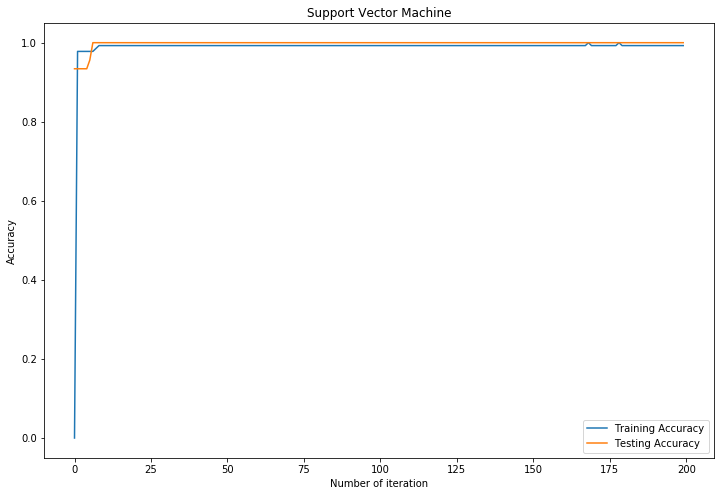

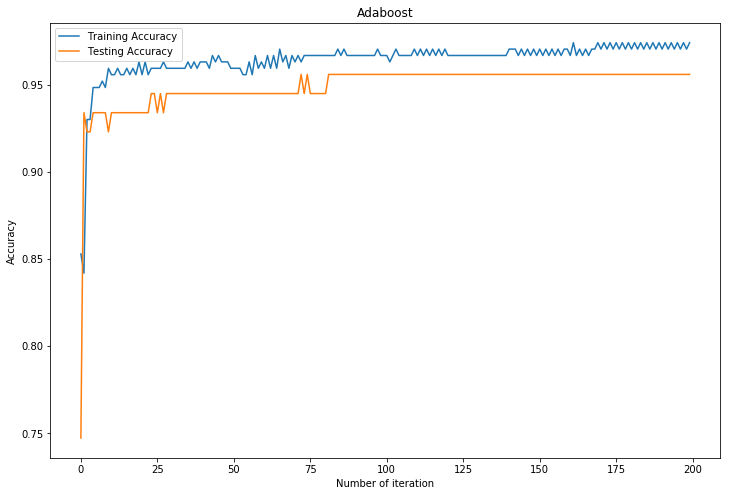

In [5]:
############################################################################
## Testing your functions and visualize the results here##
############################################################################
def testing_example():

    X_train, Y_train, X_test, Y_test = prepare_data()
    
    beta, acc_train, acc_test = my_SVM(X_train, Y_train, X_test, Y_test)
    fig = plt.figure(figsize=(12,8))
    ax = plt.plot(range(200), acc_train, range(200), acc_test)
    plt.xlabel('Number of iteration')
    plt.ylabel('Accuracy')
    plt.legend(('Training Accuracy', 'Testing Accuracy'))
    plt.title('Support Vector Machine')
    plt.show()
    
    beta, acc_train, acc_test = my_Adaboost(X_train, Y_train, X_test, Y_test)
    fig = plt.figure(figsize=(12,8))
    plt.plot(range(200), acc_train, range(200), acc_test)
    plt.xlabel('Number of iteration')
    plt.ylabel('Accuracy')
    plt.legend(('Training Accuracy', 'Testing Accuracy'))
    plt.title('Adaboost')
    plt.show()

testing_example()